# Análise exploratória de survey sociodemográfico

## Problema de pesquisa

Este dataset apresenta as respostas de um questionário aplicado com 1934 beneficiários do programa Y, com foco em integração socioeconômica e implementado pela organização X. Para entender melhor a satisfação dos beneficiários com relação ao serviço prestado, serão analisadas diferentes variáveis. A pergunta desta análise é: que fatores determinam ou influenciam a satisfação dos beneficiários do programa? 

## 0 - Importação de bibliotecas

In [71]:
# Importação de bibliotecas e pacotes

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Funções customizadas
import preditiva

# Pacote de correlação (Predictive Power Score)

#!pip install ppscore
import ppscore as pps

# Modelagem

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

## 1 - Tratamento e limpeza dos dados 

In [3]:
df = pd.read_csv("Survey_com_Problemas.csv", encoding="utf-8")
df.head()

,ID,idade,sexo,estado_civil,renda_mensal,escolaridade,tem_filhos,n_filhos,trabalha,regiao,cidade,acesso_internet,tipo_residencia,tempo_residencia_anos,meio_transporte,frequenta_escola,usa_sus,problema_saude,nivel_satisfacao,comentarios
0,1,42,fem,Viúvo,4603.72,Superior,Não,1,Sim,Nordeste,Rio de Janeiro,Sim,Outros,2.1,Carro,Não,sim,Não,3.0,Excelente
1,2,32,fem,Divorciado,1839.84,Médio,Não,4,Sim,Sudeste,São Paulo,Sim,Outros,1.5,Ônibus,Não,sim,Não,1.0,Regular
2,3,44,fem,Divorciado,3198.28,Superior,Sim,1,Sim,Sudeste,São Paulo,Sim,Cedido,1.4,Bicicleta,Não,Sim,Não,3.0,Regular
3,4,57,MASC,NaN,2827.92,Médio,Sim,2,Não,Sul,Curitiba,Sim,Própria,0.5,Carro,Não,Sim,Não,5.0,Péssimo
4,5,31,NaN,Casado,1670.44,Médio,Não,20,Sim,Nordeste,São Paulo,Sim,Própria,8.5,NaN,Sim,Não,Não,5.0,Muito bom


In [4]:
df.shape

(2010, 20)

In [5]:
# Padronizar colunas

df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace(r"[^\w\s]", "", regex=True)
df.head(5)

,id,idade,sexo,estado_civil,renda_mensal,escolaridade,tem_filhos,n_filhos,trabalha,regiao,cidade,acesso_internet,tipo_residencia,tempo_residencia_anos,meio_transporte,frequenta_escola,usa_sus,problema_saude,nivel_satisfacao,comentarios
0,1,42,fem,Viúvo,4603.72,Superior,Não,1,Sim,Nordeste,Rio de Janeiro,Sim,Outros,2.1,Carro,Não,sim,Não,3.0,Excelente
1,2,32,fem,Divorciado,1839.84,Médio,Não,4,Sim,Sudeste,São Paulo,Sim,Outros,1.5,Ônibus,Não,sim,Não,1.0,Regular
2,3,44,fem,Divorciado,3198.28,Superior,Sim,1,Sim,Sudeste,São Paulo,Sim,Cedido,1.4,Bicicleta,Não,Sim,Não,3.0,Regular
3,4,57,MASC,NaN,2827.92,Médio,Sim,2,Não,Sul,Curitiba,Sim,Própria,0.5,Carro,Não,Sim,Não,5.0,Péssimo
4,5,31,NaN,Casado,1670.44,Médio,Não,20,Sim,Nordeste,São Paulo,Sim,Própria,8.5,NaN,Sim,Não,Não,5.0,Muito bom


In [6]:
df.dtypes  # verificar possíveis erros (ex: números lidos como objeto)

id                         int64
idade                      int64
sexo                      object
estado_civil              object
renda_mensal             float64
escolaridade              object
tem_filhos                object
n_filhos                   int64
trabalha                  object
regiao                    object
cidade                    object
acesso_internet           object
tipo_residencia           object
tempo_residencia_anos    float64
meio_transporte           object
frequenta_escola          object
usa_sus                   object
problema_saude            object
nivel_satisfacao         float64
comentarios               object
dtype: object

In [7]:
# Remover colunas quase vazias
df = df.loc[:, df.isnull().mean() < 0.9]
df.isnull().sum()


id                         0
idade                      0
sexo                     411
estado_civil             407
renda_mensal               0
escolaridade             342
tem_filhos               654
n_filhos                   0
trabalha                   0
regiao                     0
cidade                     0
acesso_internet            0
tipo_residencia            0
tempo_residencia_anos      0
meio_transporte          427
frequenta_escola           0
usa_sus                    0
problema_saude           116
nivel_satisfacao         329
comentarios              390
dtype: int64

In [8]:
# Variável tem_filhos
df[df['tem_filhos'].isna()][['tem_filhos', 'n_filhos']].head()

,tem_filhos,n_filhos
5,NaN,2
6,NaN,1
13,NaN,0
17,NaN,2
18,NaN,2


In [9]:
# Se tem_filhos está ausente e n_filhos > 0 → preencher com "Sim"

df.loc[(df['tem_filhos'].isna()) & (df['n_filhos'] > 0), 'tem_filhos'] = 'Sim'
df['tem_filhos'].isna().sum()

155

In [10]:
df.loc[(df['tem_filhos'].isna()) & (df['n_filhos'] == 0), 'tem_filhos'] = 'Não'
df['tem_filhos'].isna().sum()

0

In [11]:
# PVariável sexo, escolaridade e outras

df['sexo'] = df['sexo'].fillna('Não informado')
df['escolaridade'] = df['escolaridade'].fillna('Não informado')
df['estado_civil'] = df['estado_civil'].fillna('Não informado')
df['meio_transporte'] = df['meio_transporte'].fillna('Não informado')
df['problema_saude'].fillna(df['problema_saude'].mode()[0], inplace=True)
df['nivel_satisfacao'].fillna(df['nivel_satisfacao'].mode()[0], inplace=True)
df['comentarios'].fillna(df['comentarios'].mode()[0], inplace=True)
df.isnull().sum()

id                       0
idade                    0
sexo                     0
estado_civil             0
renda_mensal             0
escolaridade             0
tem_filhos               0
n_filhos                 0
trabalha                 0
regiao                   0
cidade                   0
acesso_internet          0
tipo_residencia          0
tempo_residencia_anos    0
meio_transporte          0
frequenta_escola         0
usa_sus                  0
problema_saude           0
nivel_satisfacao         0
comentarios              0
dtype: int64

In [12]:
# Padronização de categorias

# Idade fora do intervalo razoável
df = df[df['idade'].between(0, 100)]

# Padronização de categorias
df['sexo'] = df['sexo'].str.strip().str.lower().replace({
    'masc': 'masculino',
    'fem': 'feminino'
})
df['usa_sus'] = df['usa_sus'].str.lower().str.strip()



In [13]:
# Encontrar linhas duplicadas

duplicadas = df[df.duplicated(keep=False)]
duplicadas.sort_values(by=df.columns.tolist()).head()

,id,idade,sexo,estado_civil,renda_mensal,escolaridade,tem_filhos,n_filhos,trabalha,regiao,cidade,acesso_internet,tipo_residencia,tempo_residencia_anos,meio_transporte,frequenta_escola,usa_sus,problema_saude,nivel_satisfacao,comentarios
447,448,20,feminino,Divorciado,-1244.17,Não informado,Sim,0,Sim,Sudeste,Porto Alegre,Sim,Cedido,0.2,Não informado,Não,sim,Não,1.0,Regular
2007,448,20,feminino,Divorciado,-1244.17,Não informado,Sim,0,Sim,Sudeste,Porto Alegre,Sim,Cedido,0.2,Não informado,Não,sim,Não,1.0,Regular
613,614,18,masculino,Solteiro,3206.87,Pós-graduação,Sim,1,Sim,Nordeste,Porto Alegre,Sim,Alugada,0.9,A pé,Não,sim,Não,5.0,Excelente
2006,614,18,masculino,Solteiro,3206.87,Pós-graduação,Sim,1,Sim,Nordeste,Porto Alegre,Sim,Alugada,0.9,A pé,Não,sim,Não,5.0,Excelente
674,675,13,masculino,Viúvo,3395.85,superior,Não,3,Sim,Sudeste,Belo Horizonte,Sim,Outros,0.7,Não informado,Não,não,Não,2.0,Excelente


In [14]:
df.drop_duplicates(keep='last', inplace=True)
df.duplicated().sum()

0

In [15]:
# Detecção de outliers com IQR - Idade 

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    return data[(data[column] < Q1 - 1.5 * IQR) | (data[column] > Q3 + 1.5 * IQR)]

from IPython.display import display
outliers = detect_outliers_iqr(df, 'idade')
display(outliers)


,id,idade,sexo,estado_civil,renda_mensal,escolaridade,tem_filhos,n_filhos,trabalha,regiao,cidade,acesso_internet,tipo_residencia,tempo_residencia_anos,meio_transporte,frequenta_escola,usa_sus,problema_saude,nivel_satisfacao,comentarios
209,210,92,masculino,Não informado,1760.23,superior,Não,1,Sim,Nordeste,Porto Alegre,Sim,Alugada,0.6,Não informado,Não,sim,Não,3.0,Regular
478,479,81,masculino,Viúvo,2741.50,superior,Não,2,Não,Centro-Oeste,Belo Horizonte,Sim,Própria,8.5,Ônibus,Sim,sim,Não,2.0,Regular
1615,1616,82,masculino,Não informado,850.58,Não informado,Não,1,Sim,Sul,Curitiba,Sim,Alugada,5.0,Carro,Sim,sim,Não,2.0,Excelente
1957,1958,82,feminino,Viúvo,3988.96,Superior,Sim,1,Sim,Sudeste,Rio de Janeiro,Sim,Outros,5.4,Bicicleta,Não,não,Não,2.0,Regular


In [16]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    return data[(data[column] < Q1 - 1.5 * IQR) | (data[column] > Q3 + 1.5 * IQR)]

from IPython.display import display
display(outliers)

outliers = detect_outliers_iqr(df, 'renda_mensal')

,id,idade,sexo,estado_civil,renda_mensal,escolaridade,tem_filhos,n_filhos,trabalha,regiao,cidade,acesso_internet,tipo_residencia,tempo_residencia_anos,meio_transporte,frequenta_escola,usa_sus,problema_saude,nivel_satisfacao,comentarios
209,210,92,masculino,Não informado,1760.23,superior,Não,1,Sim,Nordeste,Porto Alegre,Sim,Alugada,0.6,Não informado,Não,sim,Não,3.0,Regular
478,479,81,masculino,Viúvo,2741.50,superior,Não,2,Não,Centro-Oeste,Belo Horizonte,Sim,Própria,8.5,Ônibus,Sim,sim,Não,2.0,Regular
1615,1616,82,masculino,Não informado,850.58,Não informado,Não,1,Sim,Sul,Curitiba,Sim,Alugada,5.0,Carro,Sim,sim,Não,2.0,Excelente
1957,1958,82,feminino,Viúvo,3988.96,Superior,Sim,1,Sim,Sudeste,Rio de Janeiro,Sim,Outros,5.4,Bicicleta,Não,não,Não,2.0,Regular


In [17]:

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    return data[(data[column] < Q1 - 1.5 * IQR) | (data[column] > Q3 + 1.5 * IQR)]

from IPython.display import display
display(outliers)

outliers = detect_outliers_iqr(df, 'tempo_residencia_anos')

,id,idade,sexo,estado_civil,renda_mensal,escolaridade,tem_filhos,n_filhos,trabalha,regiao,cidade,acesso_internet,tipo_residencia,tempo_residencia_anos,meio_transporte,frequenta_escola,usa_sus,problema_saude,nivel_satisfacao,comentarios
202,203,51,feminino,Divorciado,-1649.51,Não informado,Sim,0,Sim,Nordeste,Curitiba,Sim,Própria,0.1,Carro,Sim,sim,Não,4.0,Regular
238,239,25,não informado,Não informado,-1912.52,Fundamental,Não,0,Sim,Sudeste,Rio de Janeiro,Sim,Cedido,0.1,Não informado,Sim,sim,Não,1.0,Regular
466,467,44,masculino,Não informado,7522.07,Médio,Sim,1,Sim,Nordeste,São Paulo,Sim,Própria,6.1,Não informado,Não,sim,Sim,2.0,Muito bom
823,824,29,masculino,Casado,-2373.09,Não informado,Sim,0,Sim,Norte,Rio de Janeiro,Sim,Outros,5.1,Carro,Não,sim,Não,2.0,Péssimo
902,903,35,não informado,Viúvo,-1606.73,superior,Sim,20,Sim,Centro-Oeste,Rio de Janeiro,Sim,Própria,0.3,Carro,Não,sim,Não,1.0,Muito bom
1031,1032,9,feminino,Não informado,-1680.82,superior,Sim,2,Sim,sul,Curitiba,Não,Outros,5.5,A pé,Sim,não,Não,3.0,Péssimo
1147,1148,13,masculino,Casado,-2308.29,Pós-graduação,Sim,2,Sim,Centro-Oeste,São Paulo,Sim,Própria,15.4,Carro,Não,não,Sim,5.0,Excelente
1220,1221,17,feminino,Não informado,7634.83,Pós-graduação,Não,0,Não,sul,Curitiba,Sim,Outros,1.1,A pé,Não,não,Não,4.0,Péssimo
1243,1244,19,feminino,Não informado,7250.24,Pós-graduação,Não,0,Sim,Sudeste,Porto Alegre,Sim,Outros,15.7,Não informado,Não,sim,Sim,3.0,Regular
1260,1261,43,masculino,Solteiro,7223.98,Não informado,Sim,2,Sim,Sul,São Paulo,Sim,Outros,3.7,A pé,Não,não,Não,4.0,Muito bom


In [18]:
# Regras de coerência com combinação de variáveis lógicas 


#Idade - Tempo de residencia

df_incoerente = df[df['idade'] < df['tempo_residencia_anos']]
from IPython.display import display
display(df_incoerente)

,id,idade,sexo,estado_civil,renda_mensal,escolaridade,tem_filhos,n_filhos,trabalha,regiao,cidade,acesso_internet,tipo_residencia,tempo_residencia_anos,meio_transporte,frequenta_escola,usa_sus,problema_saude,nivel_satisfacao,comentarios
79,80,5,feminino,Viúvo,6410.91,superior,Não,3,Não,Centro-Oeste,São Paulo,Sim,Outros,19.6,Não informado,Não,sim,Sim,3.0,Regular
117,118,17,feminino,Não informado,3835.10,superior,Sim,20,Sim,sul,Porto Alegre,Não,Alugada,31.0,Carro,Não,sim,Não,2.0,Péssimo
130,131,11,masculino,Solteiro,3837.94,Pós-graduação,Não,0,Sim,Centro-Oeste,São Paulo,Sim,Alugada,14.7,Ônibus,Não,não,Não,2.0,Muito bom
204,205,14,não informado,Não informado,-1.00,Não informado,Sim,4,Sim,Sul,Belo Horizonte,Sim,Outros,22.7,Carro,Não,não,Não,2.0,Péssimo
221,222,6,não informado,Solteiro,1550.42,superior,Sim,2,Sim,sul,São Paulo,Sim,Própria,6.2,Não informado,Não,não,Sim,4.0,Regular
236,237,4,feminino,Solteiro,4617.80,Médio,Sim,1,Não,Nordeste,Belo Horizonte,Sim,Própria,19.2,Bicicleta,Não,não,Não,2.0,Regular
260,261,21,masculino,Viúvo,1873.65,Fundamental,Não,0,Não,Norte,Curitiba,Sim,Alugada,25.6,Bicicleta,Não,não,Sim,5.0,Muito bom
382,383,3,feminino,Solteiro,3168.99,Médio,Sim,0,Sim,Sudeste,Belo Horizonte,Sim,Outros,3.8,Não informado,Não,não,Não,2.0,Regular
430,431,17,feminino,Divorciado,4588.17,Médio,Sim,2,Não,Nordeste,Belo Horizonte,Sim,Alugada,19.2,Não informado,Não,sim,Não,3.0,Regular
431,432,4,masculino,Não informado,3297.20,Pós-graduação,Não,0,Sim,sul,Rio de Janeiro,Sim,Cedido,6.3,A pé,Sim,não,Não,4.0,Excelente


In [19]:
df_incoerente.describe()

,id,idade,renda_mensal,n_filhos,tempo_residencia_anos,nivel_satisfacao
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,933.844444,8.088889,2854.655111,1.977778,12.588889,2.933333
std,561.762606,6.029557,1868.665760,3.018796,8.286523,1.388262
min,80.000000,0.000000,-2308.290000,0.000000,0.700000,1.000000
25%,472.000000,4.000000,1767.770000,1.000000,6.500000,2.000000
50%,926.000000,6.000000,3168.990000,2.000000,9.400000,2.000000
75%,1326.000000,12.000000,4277.360000,2.000000,19.200000,4.000000
max,1957.000000,24.000000,6410.910000,20.000000,36.200000,5.000000


In [20]:
# Para esses casos o melhor é consultar a equipe de campo, checar por agente de campo as entradas. Para os casos não tratáveis usar uma lógica para tratamento. 
# Nesse caso aplicar uma regra de cálculo

df.loc[df['idade'] < df['tempo_residencia_anos'], 'tempo_residencia_anos'] = df['idade'] * 0.5
df_incoerente = df[df['idade'] < df['tempo_residencia_anos']]
from IPython.display import display
display(df_incoerente)

,id,idade,sexo,estado_civil,renda_mensal,escolaridade,tem_filhos,n_filhos,trabalha,regiao,cidade,acesso_internet,tipo_residencia,tempo_residencia_anos,meio_transporte,frequenta_escola,usa_sus,problema_saude,nivel_satisfacao,comentarios


In [21]:
df['tempo_residencia_anos'].describe()

count    1934.000000
mean        4.714323
std         4.642099
min         0.000000
25%         1.400000
50%         3.300000
75%         6.400000
max        37.500000
Name: tempo_residencia_anos, dtype: float64

In [22]:
# Trabalho - Renda Mensal

df['incoerencia_trabalho_renda'] = (df['trabalha'] == 'Sim') & (df['renda_mensal'] <= 0)


In [23]:
df['incoerencia_trabalho_renda'].sum()

121

Vemos que temos 121 casos de 1934 com renda incoerente. Nesse caso, podemos aplicar média ou mediana. Média se os dados forem simétricos e sem muito outlier. Mediana se for assimétrica (robusta a outliers). Podemos usar uma imputação de mediana por subgrupos baseados em escolaridade. #Isso leva em conta que pessoas com diferentes níveis educacionais tendem a ter rendas diferentes.

Foram identificados 121 registros em que trabalha = Sim e renda_mensal <= 0. Considerando a incoerência entre as variáveis, esses valores foram tratados como ausentes. A imputação foi realizada com a mediana da renda por grupo de escolaridade, de forma a preservar a distribuição e o contexto socioeconômico de cada perfil."

In [24]:
df['renda_mensal'].isna().sum()

0

In [25]:
# Ter filho e número de filhos (n_filhos)

incoerentes_filhos = df[(df['tem_filhos'] == 'Não') & (df['n_filhos'] > 0)]
from IPython.display import display
display(incoerentes_filhos)

,id,idade,sexo,estado_civil,renda_mensal,escolaridade,tem_filhos,n_filhos,trabalha,regiao,...,acesso_internet,tipo_residencia,tempo_residencia_anos,meio_transporte,frequenta_escola,usa_sus,problema_saude,nivel_satisfacao,comentarios,incoerencia_trabalho_renda
0,1,42,feminino,Viúvo,4603.72,Superior,Não,1,Sim,Nordeste,...,Sim,Outros,2.1,Carro,Não,sim,Não,3.0,Excelente,False
1,2,32,feminino,Divorciado,1839.84,Médio,Não,4,Sim,Sudeste,...,Sim,Outros,1.5,Ônibus,Não,sim,Não,1.0,Regular,False
4,5,31,não informado,Casado,1670.44,Médio,Não,20,Sim,Nordeste,...,Sim,Própria,8.5,Não informado,Sim,não,Não,5.0,Muito bom,False
8,9,27,não informado,Solteiro,3349.31,Superior,Não,2,Não,sul,...,Sim,Alugada,7.6,A pé,Não,sim,Sim,2.0,Muito bom,False
10,11,28,feminino,Não informado,1561.54,Pós-graduação,Não,1,Sim,Centro-Oeste,...,Sim,Outros,1.8,A pé,Não,sim,Sim,3.0,Péssimo,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990,1991,47,não informado,Divorciado,2666.28,Pós-graduação,Não,1,Não,Norte,...,Sim,Própria,11.1,Não informado,Não,sim,Não,2.0,Péssimo,False
1992,1993,52,feminino,Divorciado,3725.67,Médio,Não,1,Não,Nordeste,...,Não,Própria,3.9,Não informado,Não,sim,Não,2.0,Regular,False
1998,1999,32,masculino,Não informado,1644.13,Médio,Não,3,Sim,Centro-Oeste,...,Sim,Alugada,0.5,Carro,Não,não,Não,2.0,Péssimo,False
2000,675,13,masculino,Viúvo,3395.85,superior,Não,3,Sim,Sudeste,...,Sim,Outros,0.7,Não informado,Não,não,Não,2.0,Excelente,False


In [26]:
df.loc[df['n_filhos'] > 0, 'tem_filhos'] = 'Sim'

In [27]:
incoerentes_filhos = df[(df['tem_filhos'] == 'Não') & (df['n_filhos'] > 0)]
from IPython.display import display
display(incoerentes_filhos)

,id,idade,sexo,estado_civil,renda_mensal,escolaridade,tem_filhos,n_filhos,trabalha,regiao,...,acesso_internet,tipo_residencia,tempo_residencia_anos,meio_transporte,frequenta_escola,usa_sus,problema_saude,nivel_satisfacao,comentarios,incoerencia_trabalho_renda


In [28]:
incoerentes_filhos_n = df[(df['tem_filhos'] == 'Não') & (df['n_filhos'] > 0)]
from IPython.display import display
display(incoerentes_filhos)

,id,idade,sexo,estado_civil,renda_mensal,escolaridade,tem_filhos,n_filhos,trabalha,regiao,...,acesso_internet,tipo_residencia,tempo_residencia_anos,meio_transporte,frequenta_escola,usa_sus,problema_saude,nivel_satisfacao,comentarios,incoerencia_trabalho_renda


In [29]:
# Padronizar nome das variáveis

df.columns = [col.capitalize() for col in df.columns]

In [30]:
# Padronizando nome das classes dentro das variáveis 

df['Usa_sus'] = df['Usa_sus'].str.strip().str.lower().str.capitalize()
df['Sexo'] = df['Sexo'].str.strip().str.lower().str.capitalize()

In [31]:
df.tail()

,Id,Idade,Sexo,Estado_civil,Renda_mensal,Escolaridade,Tem_filhos,N_filhos,Trabalha,Regiao,...,Acesso_internet,Tipo_residencia,Tempo_residencia_anos,Meio_transporte,Frequenta_escola,Usa_sus,Problema_saude,Nivel_satisfacao,Comentarios,Incoerencia_trabalho_renda
2005,1637,20,Masculino,Casado,4066.79,Não informado,Sim,2,Sim,sul,...,Sim,Cedido,0.4,Não informado,Não,Sim,Não,2.0,Regular,False
2006,614,18,Masculino,Solteiro,3206.87,Pós-graduação,Sim,1,Sim,Nordeste,...,Sim,Alugada,0.9,A pé,Não,Sim,Não,5.0,Excelente,False
2007,448,20,Feminino,Divorciado,-1244.17,Não informado,Sim,0,Sim,Sudeste,...,Sim,Cedido,0.2,Não informado,Não,Sim,Não,1.0,Regular,True
2008,1132,41,Masculino,Divorciado,2981.78,Pós-graduação,Sim,1,Sim,Sul,...,Sim,Própria,14.0,Bicicleta,Não,Não,Não,1.0,Muito bom,False
2009,809,53,Não informado,Casado,3652.62,Não informado,Sim,0,Sim,Sudeste,...,Não,Outros,0.7,Ônibus,Não,Sim,Sim,2.0,Péssimo,False


In [32]:
# Localizar renda mensal negativa 

df_negativos = df[df['Renda_mensal'] < 0]
display(df_negativos)


,Id,Idade,Sexo,Estado_civil,Renda_mensal,Escolaridade,Tem_filhos,N_filhos,Trabalha,Regiao,...,Acesso_internet,Tipo_residencia,Tempo_residencia_anos,Meio_transporte,Frequenta_escola,Usa_sus,Problema_saude,Nivel_satisfacao,Comentarios,Incoerencia_trabalho_renda
17,18,39,Feminino,Divorciado,-1.00,Pós-graduação,Sim,2,Sim,Nordeste,...,Sim,Cedido,2.1,Carro,Não,Sim,Não,4.0,Muito bom,True
26,27,17,Não informado,Viúvo,-1.00,superior,Sim,0,Sim,Centro-Oeste,...,Não,Própria,7.8,Não informado,Não,Sim,Não,1.0,Regular,True
48,49,40,Não informado,Casado,-1.00,Pós-graduação,Sim,3,Sim,Norte,...,Não,Alugada,5.4,A pé,Sim,Sim,Não,3.0,Muito bom,True
70,71,40,Não informado,Viúvo,-1.00,superior,Sim,1,Sim,Norte,...,Sim,Própria,12.2,A pé,Sim,Sim,Não,1.0,Regular,True
77,78,30,Masculino,Viúvo,-1.00,Pós-graduação,Sim,2,Sim,Nordeste,...,Sim,Outros,0.3,A pé,Não,Sim,Não,1.0,Regular,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928,1929,51,Feminino,Solteiro,-106.77,Médio,Sim,2,Sim,Sudeste,...,Sim,Cedido,7.3,Não informado,Não,Sim,Não,2.0,Regular,True
1938,1939,51,Feminino,Viúvo,-95.83,superior,Sim,3,Não,Nordeste,...,Sim,Alugada,0.7,Ônibus,Sim,Sim,Sim,2.0,Regular,False
1940,1941,39,Feminino,Não informado,-1.00,Não informado,Sim,1,Sim,sul,...,Sim,Cedido,0.8,A pé,Não,Sim,Não,2.0,Péssimo,True
1969,1970,52,Masculino,Viúvo,-1.00,Superior,Sim,3,Sim,sul,...,Sim,Alugada,0.1,Bicicleta,Não,Não,Não,1.0,Excelente,True


In [33]:
# Imputar número absoluto nos valores negativos

df['Renda_mensal_original'] = df['Renda_mensal']


In [34]:
df.loc[df['Renda_mensal'] < 0, 'Renda_mensal'] = df['Renda_mensal'].abs()
display(df[df['Renda_mensal_original'] < 0][['Renda_mensal_original', 'Renda_mensal']])

,Renda_mensal_original,Renda_mensal
17,-1.00,1.00
26,-1.00,1.00
48,-1.00,1.00
70,-1.00,1.00
77,-1.00,1.00
...,...,...
1928,-106.77,106.77
1938,-95.83,95.83
1940,-1.00,1.00
1969,-1.00,1.00


No dia 20/06 foi realizada uma reunião com os especialistas em integração socioeconômica. Chegou-se a conclusão que rendas mensais menores que R$ 100,00 são irrealistas. Veja abaixo os valores para a amostra 

<Axes: xlabel='Renda_mensal', ylabel='Count'>

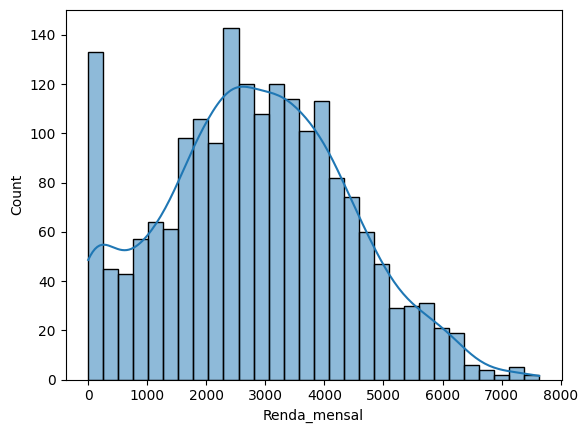

In [58]:
sns.histplot(df['Renda_mensal'], bins=30, kde=True)

In [35]:
# Mediana aplicada como imputação para casos em que renda mensal < 100, respeitando subgrupos de escolaridade

def substituir_por_mediana_grupo(x):
    mediana = x.median()
    return x.apply(lambda valor: mediana if valor < 100 else valor)

df['Renda_mensal'] = df.groupby('Escolaridade')['Renda_mensal'].transform(substituir_por_mediana_grupo)

In [36]:
display(df[df['Renda_mensal_original'] < 100][['Renda_mensal_original', 'Renda_mensal', 'Escolaridade']])

,Renda_mensal_original,Renda_mensal,Escolaridade
17,-1.00,2792.65,Pós-graduação
26,-1.00,2698.48,superior
48,-1.00,2792.65,Pós-graduação
70,-1.00,2698.48,superior
77,-1.00,2792.65,Pós-graduação
...,...,...,...
1928,-106.77,106.77,Médio
1938,-95.83,2698.48,superior
1940,-1.00,2956.80,Não informado
1969,-1.00,2731.52,Superior


In [37]:
# Identificando idades menores que 18 anos 

df_idad_abaix_18 = df[df['Idade'] < 18]

display(df_idad_abaix_18)

,Id,Idade,Sexo,Estado_civil,Renda_mensal,Escolaridade,Tem_filhos,N_filhos,Trabalha,Regiao,...,Tipo_residencia,Tempo_residencia_anos,Meio_transporte,Frequenta_escola,Usa_sus,Problema_saude,Nivel_satisfacao,Comentarios,Incoerencia_trabalho_renda,Renda_mensal_original
13,14,6,Feminino,Casado,860.82,Superior,Não,0,Sim,Norte,...,Outros,1.7,Não informado,Sim,Sim,Não,2.0,Péssimo,False,860.82
19,20,13,Feminino,Divorciado,588.16,Não informado,Não,0,Não,Sul,...,Cedido,0.2,Bicicleta,Não,Sim,Não,4.0,Regular,False,588.16
23,24,13,Feminino,Divorciado,1734.90,Não informado,Sim,2,Sim,sul,...,Alugada,6.0,Bicicleta,Não,Sim,Não,2.0,Péssimo,False,1734.90
26,27,17,Não informado,Viúvo,2698.48,superior,Sim,0,Sim,Centro-Oeste,...,Própria,7.8,Não informado,Não,Sim,Não,1.0,Regular,True,-1.00
35,36,16,Feminino,Divorciado,4747.99,superior,Sim,0,Sim,Centro-Oeste,...,Outros,4.8,Não informado,Não,Sim,Não,4.0,Excelente,False,4747.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956,1957,2,Não informado,Não informado,1342.91,Fundamental,Sim,3,Sim,sul,...,Própria,1.0,Bicicleta,Não,Não,Sim,2.0,Péssimo,False,1342.91
1981,1982,14,Masculino,Viúvo,4750.81,Médio,Sim,1,Sim,Sudeste,...,Alugada,8.7,Ônibus,Não,Não,Não,3.0,Péssimo,False,4750.81
2000,675,13,Masculino,Viúvo,3395.85,superior,Sim,3,Sim,Sudeste,...,Outros,0.7,Não informado,Não,Não,Não,2.0,Excelente,False,3395.85
2003,1316,15,Masculino,Viúvo,4963.70,Superior,Não,0,Sim,Centro-Oeste,...,Outros,6.1,Não informado,Não,Não,Não,1.0,Regular,False,4963.70


In [38]:
# Salvar coluna com valores originais e imputar mediana com base em subgrupos para valores abaixo de 18

df['Idade_original'] = df['Idade']
# (opcional) Imputar com mediana do grupo
# Marcar as idades inválidas como NaN
df.loc[df['Idade'] < 18, 'Idade'] = pd.NA
# Imputar a mediana do grupo
df['Idade'] = df.groupby('Escolaridade')['Idade'].transform(lambda x: x.fillna(x.median()))

In [39]:
display(df[df['Idade_original'] < 18][['Idade_original', 'Idade', 'Escolaridade']])

,Idade_original,Idade,Escolaridade
13,6,38.0,Superior
19,13,36.0,Não informado
23,13,36.0,Não informado
26,17,37.0,superior
35,16,37.0,superior
...,...,...,...
1956,2,39.0,Fundamental
1981,14,38.0,Médio
2000,13,37.0,superior
2003,15,38.0,Superior


In [40]:
df.isna().sum()

Id                            0
Idade                         0
Sexo                          0
Estado_civil                  0
Renda_mensal                  0
Escolaridade                  0
Tem_filhos                    0
N_filhos                      0
Trabalha                      0
Regiao                        0
Cidade                        0
Acesso_internet               0
Tipo_residencia               0
Tempo_residencia_anos         0
Meio_transporte               0
Frequenta_escola              0
Usa_sus                       0
Problema_saude                0
Nivel_satisfacao              0
Comentarios                   0
Incoerencia_trabalho_renda    0
Renda_mensal_original         0
Idade_original                0
dtype: int64

## 2 - Análise unidimensional e bidimensional das variáveis 

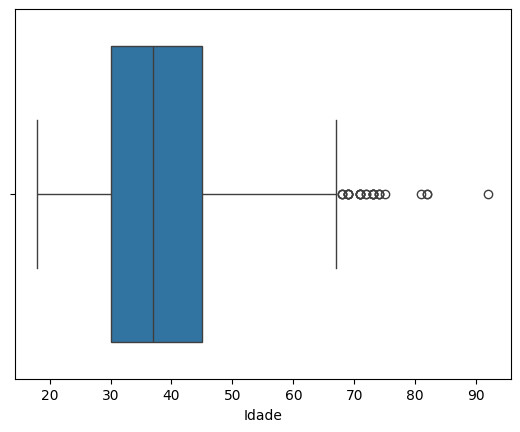

In [89]:
# Visualização de variáveis

sns.boxplot(x='Idade', data=df)
plt.show()

<Axes: xlabel='Idade', ylabel='Count'>

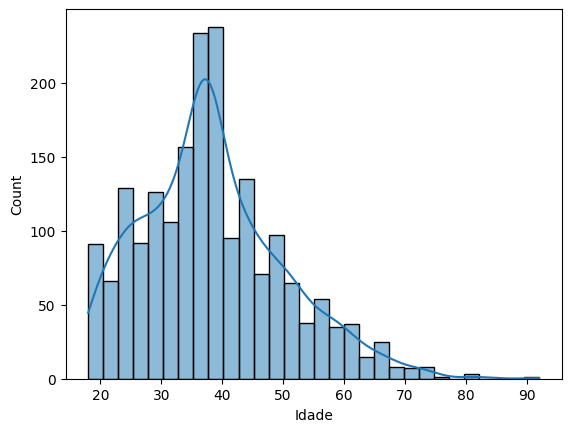

In [90]:
sns.histplot(df['Idade'], bins=30, kde=True)

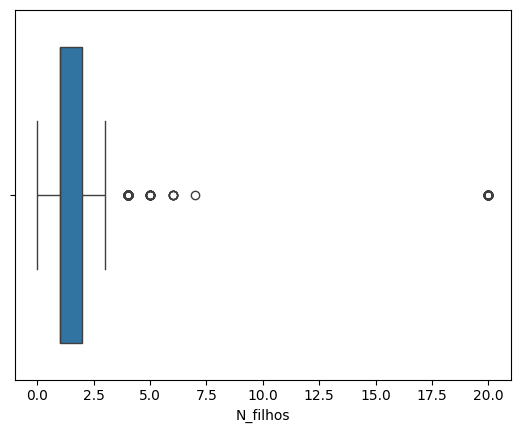

In [92]:
sns.boxplot(x='N_filhos', data=df)
plt.show()

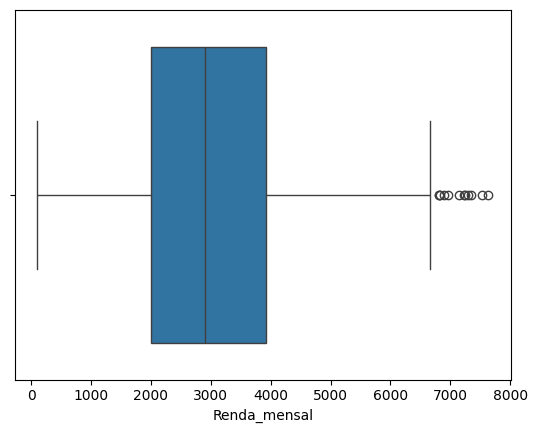

In [93]:
sns.boxplot(x='Renda_mensal', data=df)
plt.show()

<Axes: xlabel='Renda_mensal', ylabel='Count'>

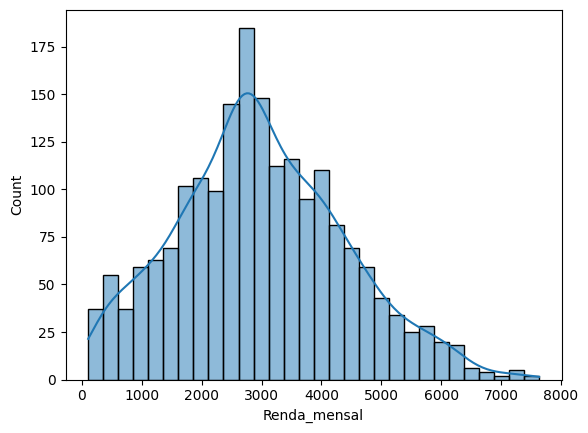

In [95]:
sns.histplot(df['Renda_mensal'], bins=30, kde=True)

<Axes: xlabel='Tempo_residencia_anos', ylabel='Count'>

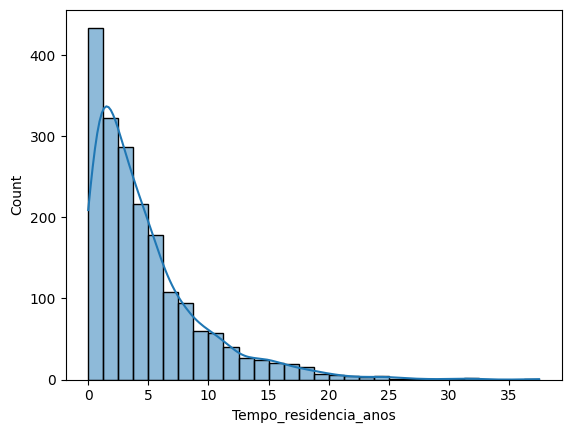

In [94]:
sns.histplot(df['Tempo_residencia_anos'], bins=30, kde=True)	

<Axes: xlabel='Nivel_satisfacao', ylabel='Count'>

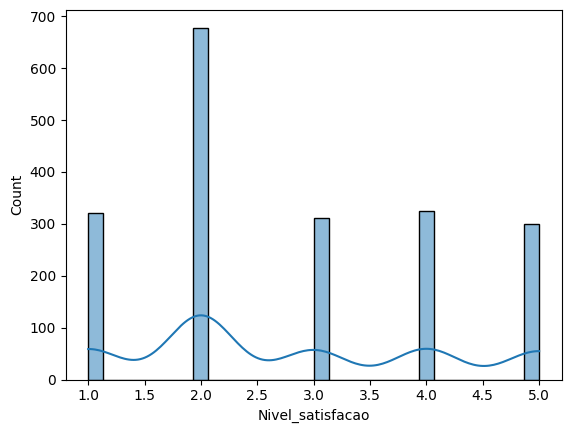

In [96]:
sns.histplot(df['Nivel_satisfacao'], bins=30, kde=True)	

<Axes: xlabel='Sexo', ylabel='Idade'>

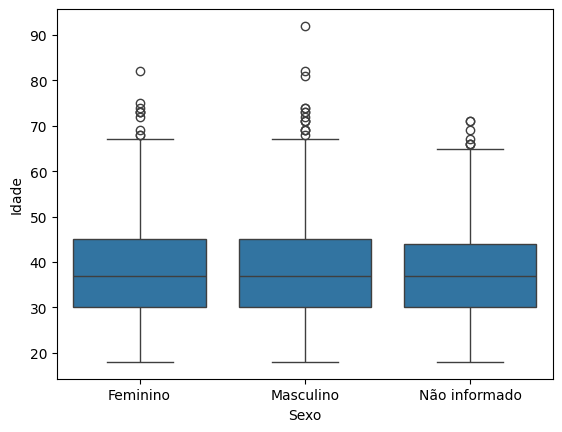

In [97]:
sns.boxplot(x=df['Sexo'], y=df['Idade'])

<Axes: xlabel='Renda_mensal', ylabel='Estado_civil'>

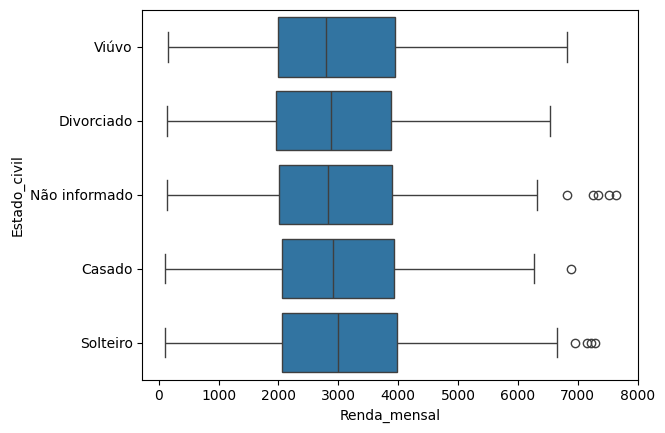

In [98]:
sns.boxplot(x=df['Renda_mensal'], y=df['Estado_civil'])

<Axes: xlabel='Renda_mensal', ylabel='Trabalha'>

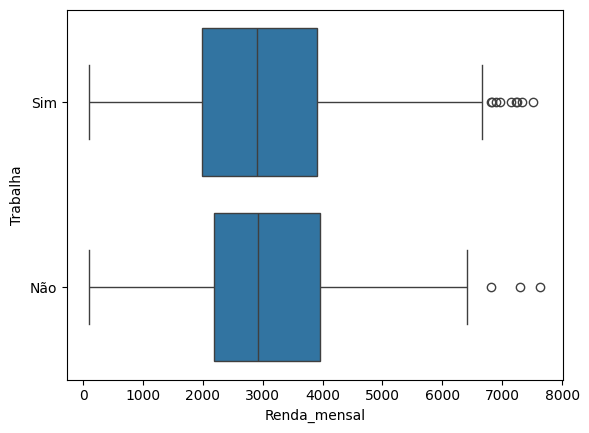

In [99]:
sns.boxplot(x=df['Renda_mensal'], y=df['Trabalha'])

<Axes: xlabel='Renda_mensal', ylabel='Regiao'>

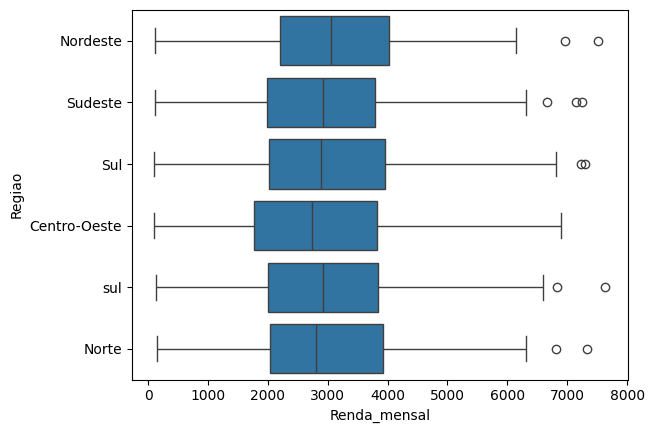

In [101]:
sns.boxplot(x=df['Renda_mensal'], y=df['Regiao'])

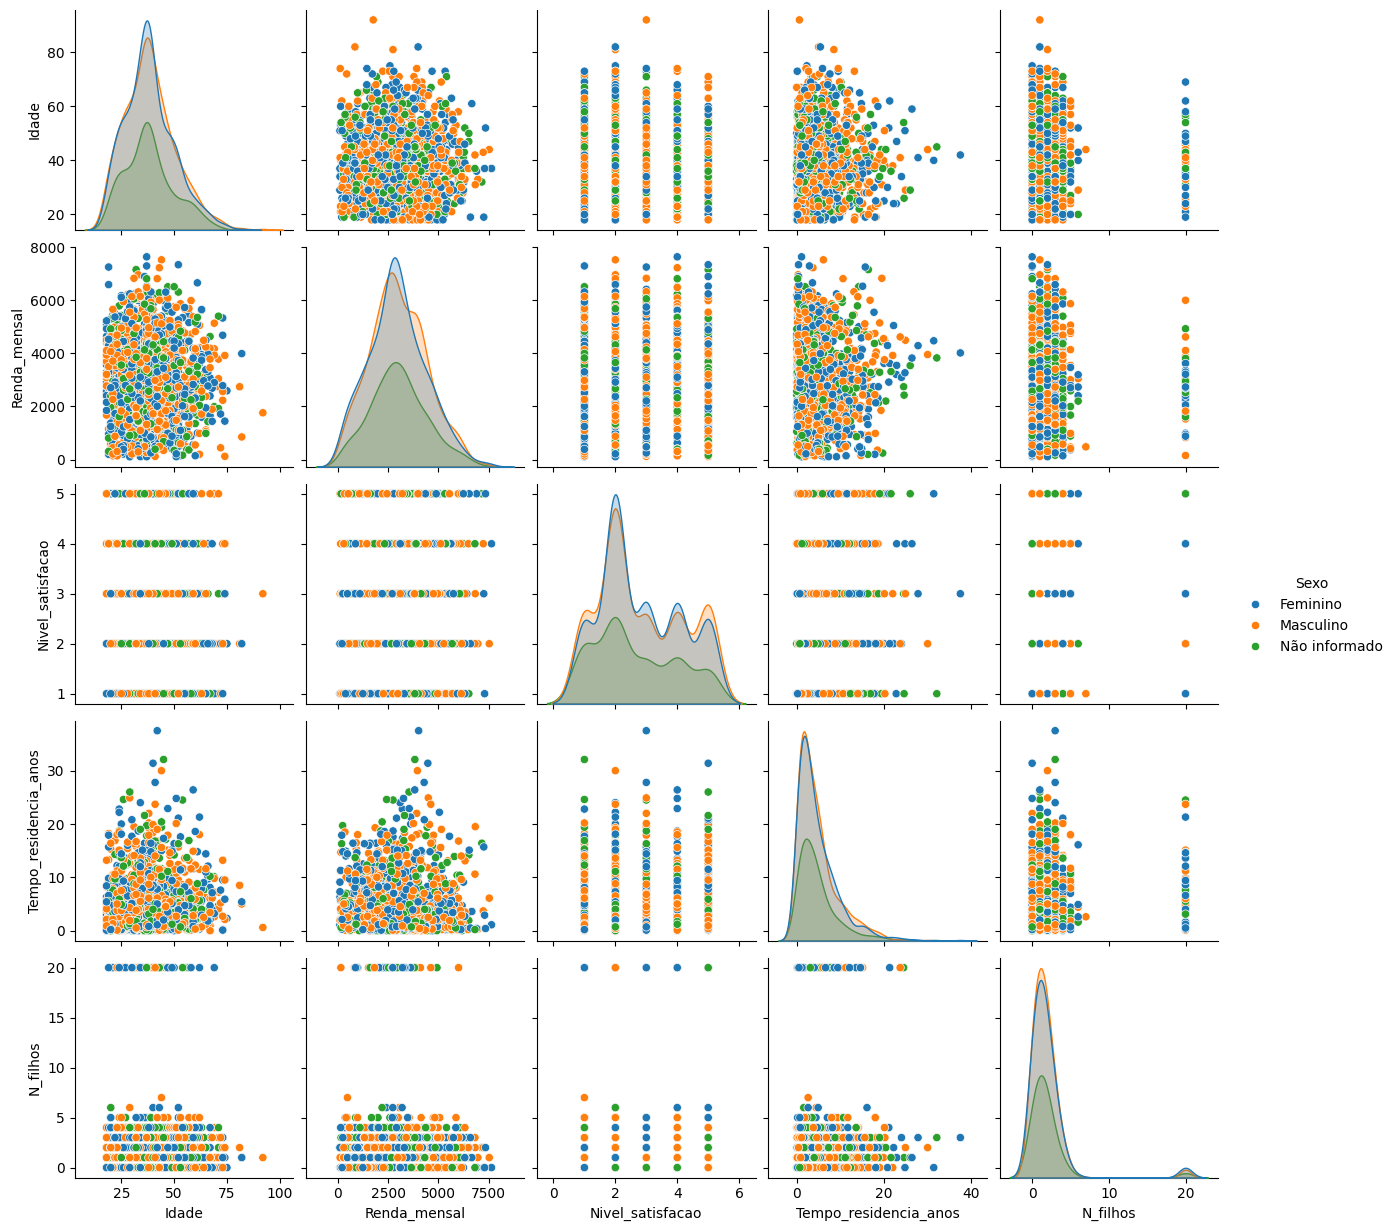

In [112]:
df_plot = df[['Idade', 'Renda_mensal', 'Nivel_satisfacao', 'Tempo_residencia_anos', 'N_filhos', 'Sexo']]
sns.pairplot(df_plot, hue='Sexo', diag_kind='kde')

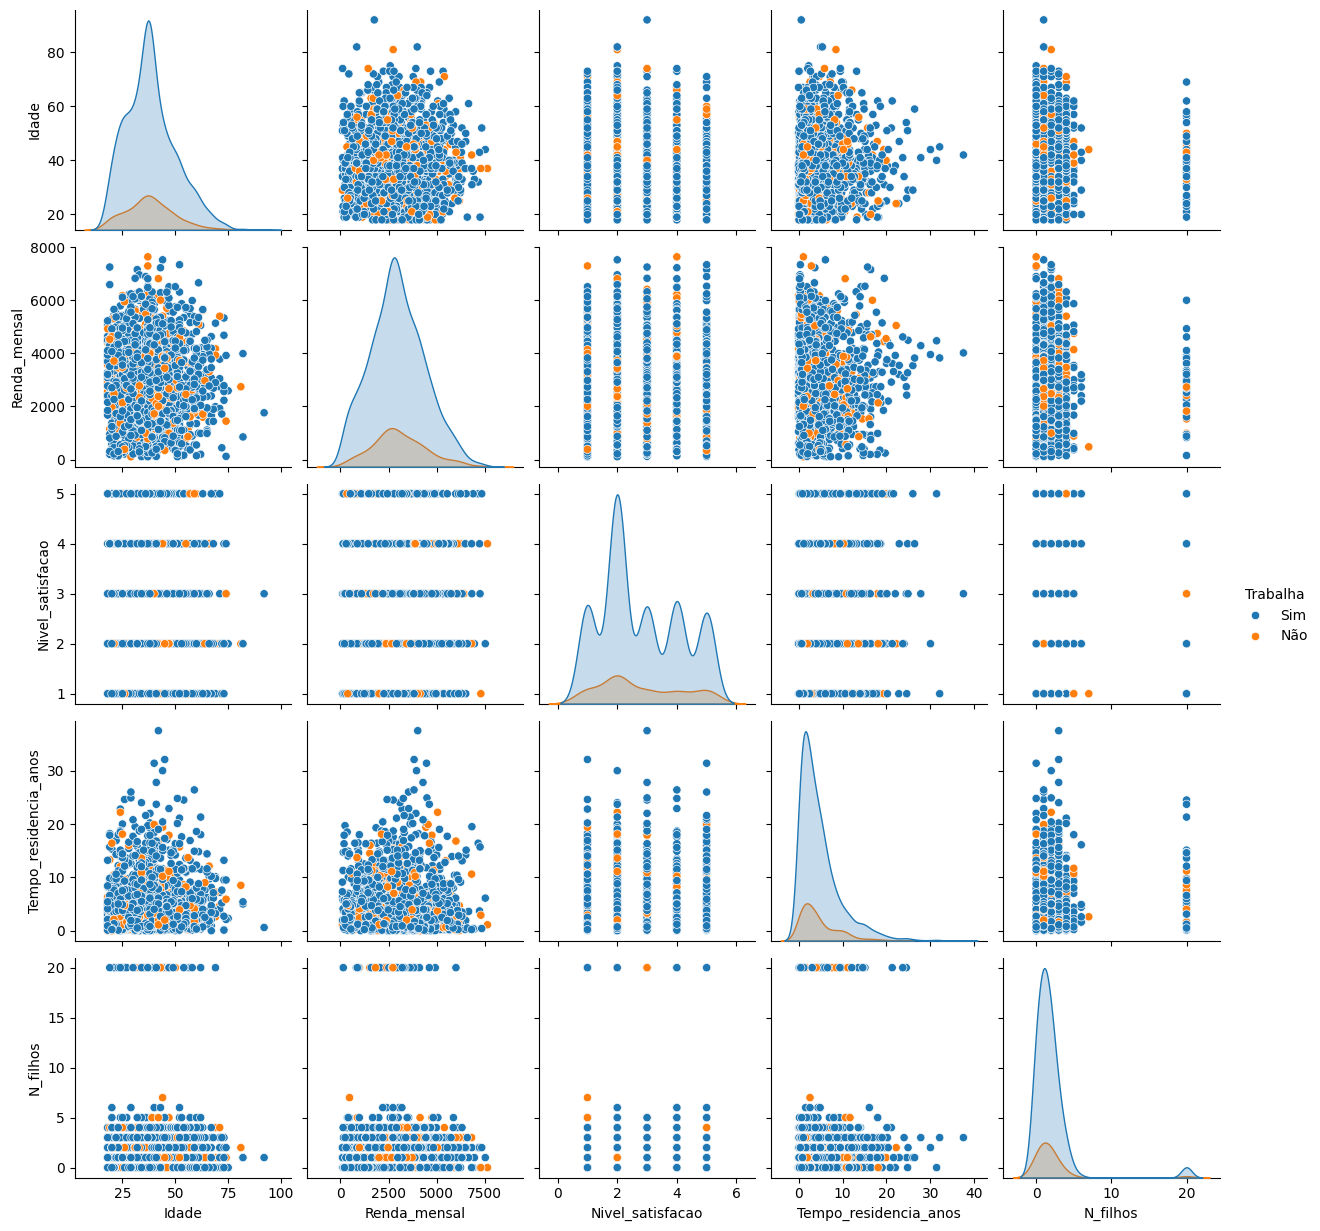

In [113]:
df_plot = df[['Idade', 'Renda_mensal', 'Nivel_satisfacao', 'Tempo_residencia_anos', 'N_filhos', 'Trabalha']]
sns.pairplot(df_plot, hue='Trabalha', diag_kind='kde')

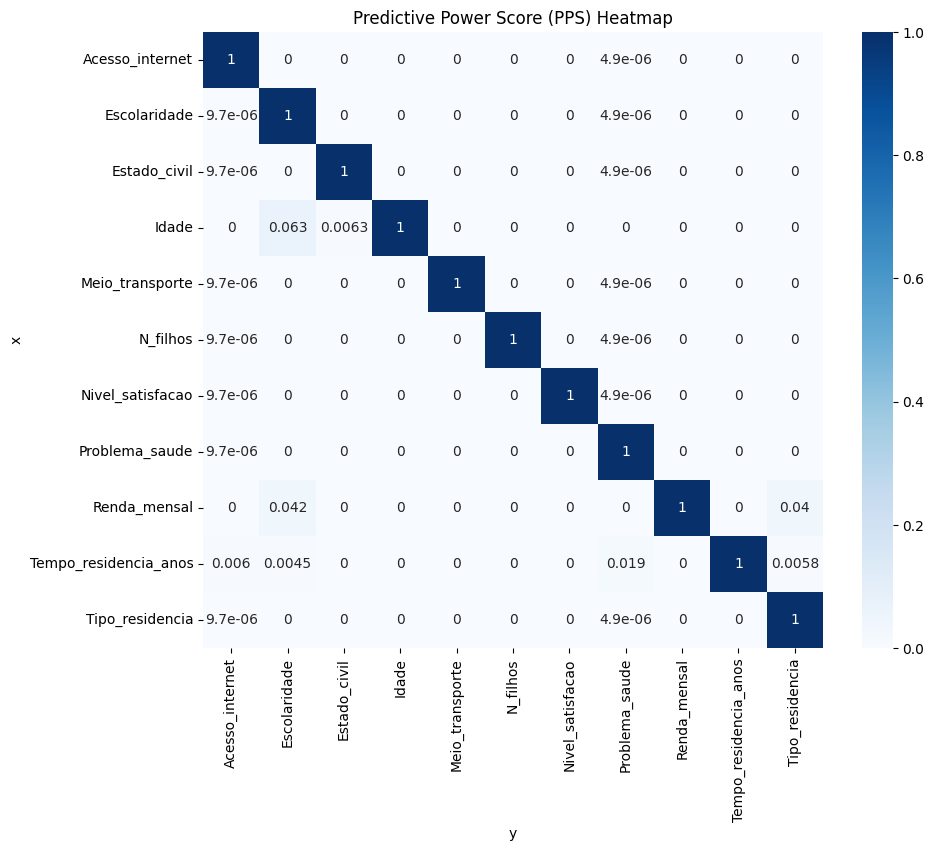

In [114]:
# Correlação 
colunas_interesse = ['Idade', 'Renda_mensal', 'Nivel_satisfacao', 'Tempo_residencia_anos', 'N_filhos', 'Escolaridade', 'Estado_civil', 'Meio_transporte', 'Problema_saude', 'Acesso_internet', 'Tipo_residencia']
pps_matrix = pps.matrix(df[colunas_interesse])
pps_pivot = pps_matrix.pivot(index='x', columns='y', values='ppscore')
plt.figure(figsize=(10,8))
sns.heatmap(pps_pivot, annot=True, cmap="Blues", vmin=0, vmax=1)
plt.title("Predictive Power Score (PPS) Heatmap")
plt.show();

A matriz de correlação do Power Predict Score mostra que há uma correlação leve entre idade e escolaridade, bem como renda mensal e escolaridade. Também há uma correlação leve entre tipo de residência e renda mensal. QUando calculamos Pearson identificamos que tempo de residência está levemente associado à número de filhos.  

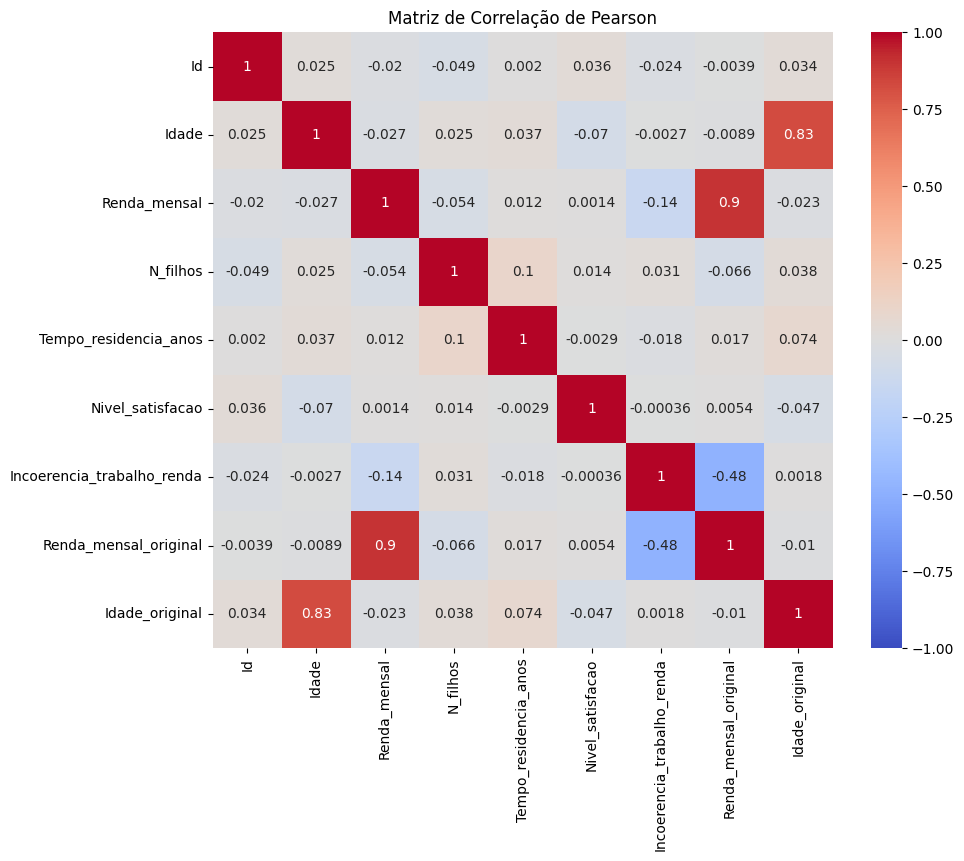

In [106]:
correlacao_pearson = df.corr(method='pearson')

plt.figure(figsize=(10,8))
sns.heatmap(correlacao_pearson, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação de Pearson')
plt.show()

In [ ]:
sns.pairplot(df[['Idade', 'Renda_mensal', 'OutraVariavel']])

## 3 - Pré-processamento para modelagem 

Vamos criar um código para construir uma variável nova com base na variável "Nivel de satisfacao". Criaremos uma classificação categórica (ordinária) para esta nova coluna. Para isso, as definições de baixa, média e alta foram definidas em colaboração com a equipe do projeto.


In [42]:
# Função para criar nova variável
def classificar_satisfacao(nota):
    if nota <= 2:
        return 'Baixa'
    elif nota <= 4:
        return 'Média'
    else:
        return 'Alta'

df['Satisfacao_cat'] = df['Nivel_satisfacao'].apply(classificar_satisfacao)


In [43]:
print(df['Satisfacao_cat'].value_counts())

Baixa    999
Média    635
Alta     300
Name: Satisfacao_cat, dtype: int64


In [44]:
# Parcionamento em treino e teste

x = df[['Idade', 'Renda_mensal', 'Tempo_residencia_anos',
        'N_filhos', 'Sexo', 'Estado_civil', 'Escolaridade', 
        'Acesso_internet', 'Tipo_residencia', 'Meio_transporte', 
        'Frequenta_escola', 'Usa_sus', 'Problema_saude']]

y = df['Satisfacao_cat']

num_cols = ['Idade', 'Renda_mensal', 'Tempo_residencia_anos', 'N_filhos']

cat_cols = ['Sexo', 'Estado_civil', 'Escolaridade', 'Acesso_internet', 'Tipo_residencia',
            'Meio_transporte', 'Frequenta_escola', 'Usa_sus', 'Problema_saude']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [45]:
x_train

,Idade,Renda_mensal,Tempo_residencia_anos,N_filhos,Sexo,Estado_civil,Escolaridade,Acesso_internet,Tipo_residencia,Meio_transporte,Frequenta_escola,Usa_sus,Problema_saude
776,24.0,1767.77,12.0,1,Feminino,Solteiro,superior,Não,Própria,Ônibus,Sim,Não,Sim
1499,43.0,2698.48,13.6,4,Não informado,Casado,superior,Sim,Outros,Carro,Não,Sim,Sim
972,47.0,3443.34,4.1,0,Feminino,Solteiro,Fundamental,Sim,Própria,Bicicleta,Não,Não,Não
507,22.0,2792.65,0.9,1,Masculino,Divorciado,Pós-graduação,Sim,Alugada,Ônibus,Não,Sim,Não
1322,33.0,1648.54,3.9,0,Feminino,Solteiro,Superior,Sim,Cedido,Ônibus,Não,Não,Não
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,23.0,2756.58,9.7,1,Feminino,Viúvo,superior,Sim,Própria,Bicicleta,Não,Não,Não
1345,36.0,1476.56,1.9,4,Masculino,Viúvo,Não informado,Não,Outros,Bicicleta,Não,Sim,Não
893,52.0,1988.38,3.2,1,Feminino,Não informado,Fundamental,Não,Cedido,A pé,Não,Não,Sim
1516,57.0,361.27,2.1,3,Não informado,Divorciado,superior,Sim,Outros,A pé,Não,Não,Não


## 4 - Treinamento e teste do modelo 

In [46]:
# Árvore de decisão 

from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Pré-processamento
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    # Não precisa do 'num' com scaler
], remainder='passthrough')  # Deixe passar as numéricas como estão

# Pipeline com árvore de decisão
pipeline_dt = Pipeline([
    ('preprocess', preprocessor),
    ('model', DecisionTreeClassifier(max_depth=4, min_samples_split=10, random_state=42))
])


In [47]:
x_train

,Idade,Renda_mensal,Tempo_residencia_anos,N_filhos,Sexo,Estado_civil,Escolaridade,Acesso_internet,Tipo_residencia,Meio_transporte,Frequenta_escola,Usa_sus,Problema_saude
776,24.0,1767.77,12.0,1,Feminino,Solteiro,superior,Não,Própria,Ônibus,Sim,Não,Sim
1499,43.0,2698.48,13.6,4,Não informado,Casado,superior,Sim,Outros,Carro,Não,Sim,Sim
972,47.0,3443.34,4.1,0,Feminino,Solteiro,Fundamental,Sim,Própria,Bicicleta,Não,Não,Não
507,22.0,2792.65,0.9,1,Masculino,Divorciado,Pós-graduação,Sim,Alugada,Ônibus,Não,Sim,Não
1322,33.0,1648.54,3.9,0,Feminino,Solteiro,Superior,Sim,Cedido,Ônibus,Não,Não,Não
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,23.0,2756.58,9.7,1,Feminino,Viúvo,superior,Sim,Própria,Bicicleta,Não,Não,Não
1345,36.0,1476.56,1.9,4,Masculino,Viúvo,Não informado,Não,Outros,Bicicleta,Não,Sim,Não
893,52.0,1988.38,3.2,1,Feminino,Não informado,Fundamental,Não,Cedido,A pé,Não,Não,Sim
1516,57.0,361.27,2.1,3,Não informado,Divorciado,superior,Sim,Outros,A pé,Não,Não,Não


In [48]:
pipeline_dt.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sexo', 'Estado_civil',
                                                   'Escolaridade',
                                                   'Acesso_internet',
                                                   'Tipo_residencia',
                                                   'Meio_transporte',
                                                   'Frequenta_escola',
                                                   'Usa_sus',
                                                   'Problema_saude'])])),
                ('model',
                 DecisionTreeClassifier(max_depth=4, min_samples_split=10,
                                        random_state=42))])

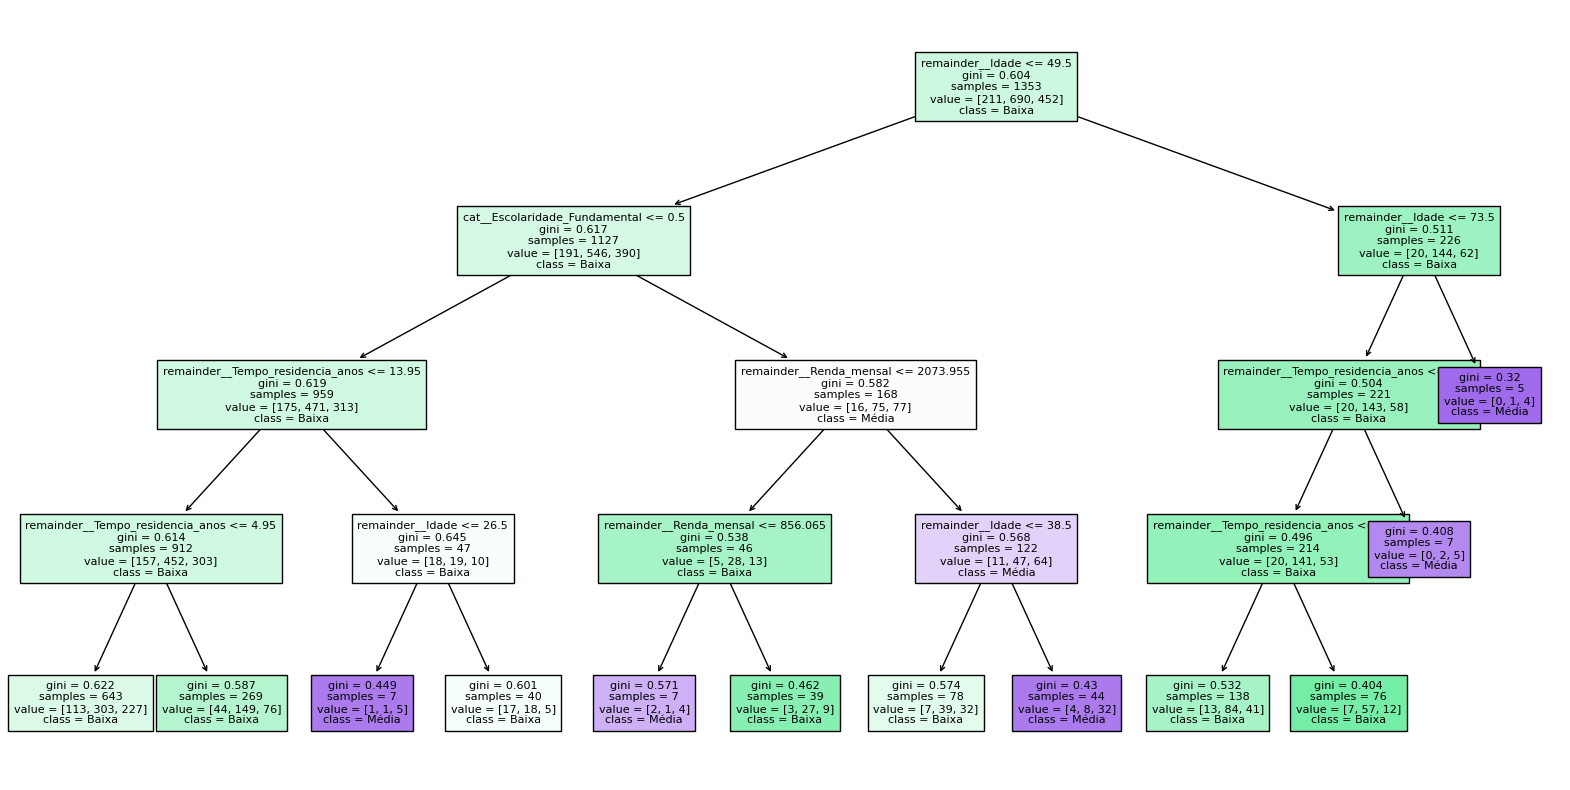

In [49]:
from sklearn import tree
import matplotlib.pyplot as plt

# Extraia o modelo já treinado
modelo_ajustado = pipeline_dt.named_steps['model']

plt.figure(figsize=(20,10))
tree.plot_tree(modelo_ajustado, filled=True, feature_names=pipeline_dt.named_steps['preprocess'].get_feature_names_out(), class_names=pipeline_dt.classes_, fontsize=8)
plt.show()

## 5 - Análise de desempenho do modelo 

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Previsões
y_pred = pipeline_dt.predict(x_test)
y_proba = pipeline_dt.predict_proba(x_test)

# Acurácia
print("Acurácia:", accuracy_score(y_test, y_pred))

# Precision, Recall, F1
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))

Acurácia: 0.5077452667814114
Precision (macro): 0.2792026731190229
Recall (macro): 0.3308575167559729
F1-score (macro): 0.26957513544339895


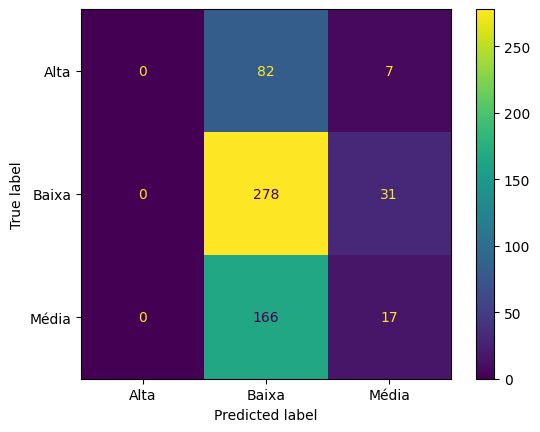

In [51]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=pipeline_dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_dt.classes_)
disp.plot()
plt.show()

In [171]:
# ROC-AUC (para multiclasse)
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
print("ROC-AUC (macro):", roc_auc)

ROC-AUC (macro): 0.5084367149246699


## 6 - Soluções para aprimoramento do modelo 

In [83]:
# Modelo Baseline - Random Forest 
# Crie o pipeline sem oversampling
pipeline_rf_puro = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

# Treine
pipeline_rf_puro.fit(x_train, y_train)

# Previsões
y_pred_puro = pipeline_rf_puro.predict(x_test)

# Avaliação
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("== Random Forest sem balanceamento ==")
print("Acurácia:", accuracy_score(y_test, y_pred_puro))
print("F1 macro:", f1_score(y_test, y_pred_puro, average='macro'))
print("\nRelatório:\n", classification_report(y_test, y_pred_puro))

== Random Forest sem balanceamento ==
Acurácia: 0.4939759036144578
F1 macro: 0.2987745810780809

Relatório:
               precision    recall  f1-score   support

        Alta       0.12      0.01      0.02        89
       Baixa       0.53      0.82      0.65       309
       Média       0.33      0.17      0.23       183

    accuracy                           0.49       581
   macro avg       0.33      0.34      0.30       581
weighted avg       0.41      0.49      0.42       581



In [60]:
# Comparação de Random Oversampling e SMOTE (técnicas de oversampling)

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy = 'not majority', random_state=42)
x_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)

In [61]:
# Ver proporção

print(y_train_ros.value_counts(normalize=True))  # proporção em %
print(y_train_ros.value_counts())               # contagem absoluta

Média    0.333333
Alta     0.333333
Baixa    0.333333
Name: Satisfacao_cat, dtype: float64
Média    690
Alta     690
Baixa    690
Name: Satisfacao_cat, dtype: int64


In [58]:
print(df['Satisfacao_cat'].value_counts())

Baixa    999
Média    635
Alta     300
Name: Satisfacao_cat, dtype: int64


In [66]:
# Transformar variáveis em dummy (obrigatório para Random Forest) + Oversample (not minority) + Treinar no modelo Random Forest
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('oversample', RandomOverSampler(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])

pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sexo', 'Estado_civil',
                                                   'Escolaridade',
                                                   'Acesso_internet',
                                                   'Tipo_residencia',
                                                   'Meio_transporte',
                                                   'Frequenta_escola',
                                                   'Usa_sus',
                                                   'Problema_saude'])])),
                ('oversample', RandomOverSampler(random_state=42)),
                ('model', RandomForestClassifier(random_state=42))])

In [67]:
# Avaliar métricas de desempenho

print("== Random Oversampling ==")
print("Acurácia:", accuracy_score(y_test, y_pred))
print("F1 macro:", f1_score(y_test, y_pred, average='macro'))
print("\nRelatório:\n", classification_report(y_test, y_pred))

== Random Oversampling ==
Acurácia: 0.5077452667814114
F1 macro: 0.26957513544339895

Relatório:
               precision    recall  f1-score   support

        Alta       0.00      0.00      0.00        89
       Baixa       0.53      0.90      0.67       309
       Média       0.31      0.09      0.14       183

    accuracy                           0.51       581
   macro avg       0.28      0.33      0.27       581
weighted avg       0.38      0.51      0.40       581



In [68]:
print(y_train.value_counts())

Baixa    690
Média    452
Alta     211
Name: Satisfacao_cat, dtype: int64


In [69]:
# Comparação com desempenho baseline

# Acurácia
print("Acurácia:", accuracy_score(y_test, y_pred))
# Precision, Recall, F1
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))

Acurácia: 0.5077452667814114
Precision (macro): 0.2792026731190229
Recall (macro): 0.3308575167559729
F1-score (macro): 0.26957513544339895


In [72]:
# SMOTE Oversampling 

#Oversample (not minority) + Treinar no modelo Random Forest

pipeline_smote = Pipeline([
    ('preprocess', preprocessor),
    ('oversample', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])

pipeline_smote.fit(x_train, y_train)

y_pred_smote = pipeline_smote.predict(x_test)

In [73]:
# Avaliar métricas de desempenho

print("Acurácia:", accuracy_score(y_test, y_pred_smote))
print("F1 macro:", f1_score(y_test, y_pred_smote, average='macro'))
print("\nRelatório:\n", classification_report(y_test, y_pred_smote))

Acurácia: 0.49225473321858865
F1 macro: 0.3289271458546821

Relatório:
               precision    recall  f1-score   support

        Alta       0.19      0.06      0.09        89
       Baixa       0.55      0.79      0.65       309
       Média       0.32      0.20      0.25       183

    accuracy                           0.49       581
   macro avg       0.36      0.35      0.33       581
weighted avg       0.43      0.49      0.44       581



Testei o modelo Random Forest combinado com técnicas de oversampling (mais aplicável para datasets menores). Apliquei Random Oversampling e SMOTE. Os conjuntos de dados oversampled foram aplicados no Random Forest e as métricas de desempenho foram comparadas. SMOTE melhorou um pouco a predição das classes minoritárias, mas ainda não tornou o modelo bom o suficiente. 

In [77]:
importances = pipeline_smote.named_steps['model'].feature_importances_
features = pipeline_smote.named_steps['preprocess'].get_feature_names_out()

import pandas as pd
df_imp = pd.DataFrame({'feature': features, 'importance': importances})
print(df_imp.sort_values(by='importance', ascending=False).head(10))

                             feature  importance
32           remainder__Renda_mensal    0.096141
33  remainder__Tempo_residencia_anos    0.090604
31                  remainder__Idade    0.089723
34               remainder__N_filhos    0.057448
3           cat__Estado_civil_Casado    0.030703
18       cat__Tipo_residencia_Outros    0.028250
1                cat__Sexo_Masculino    0.027251
11   cat__Escolaridade_Pós-graduação    0.026800
0                 cat__Sexo_Feminino    0.026218
24       cat__Meio_transporte_Ônibus    0.026169


In [81]:
# Uso do Balanced Random Forest 

from imblearn.ensemble import BalancedRandomForestClassifier

pipeline_bal_rf = Pipeline([
    ('preprocess', preprocessor),
    ('model', BalancedRandomForestClassifier(random_state=42))
])

pipeline_bal_rf.fit(x_train, y_train)
y_pred_bal_rf = pipeline_bal_rf.predict(x_test)

print("Acurácia:", accuracy_score(y_test, y_pred_bal_rf))
print("F1 macro:", f1_score(y_test, y_pred_bal_rf, average='macro'))
print("\nRelatório:\n", classification_report(y_test, y_pred_bal_rf))

Acurácia: 0.3253012048192771
F1 macro: 0.3037997204219088

Relatório:
               precision    recall  f1-score   support

        Alta       0.15      0.31      0.20        89
       Baixa       0.51      0.34      0.41       309
       Média       0.30      0.30      0.30       183

    accuracy                           0.33       581
   macro avg       0.32      0.32      0.30       581
weighted avg       0.39      0.33      0.34       581



In [84]:
# Comparação com baseline 

print("== Random Forest sem balanceamento ==")
print("Acurácia:", accuracy_score(y_test, y_pred_puro))
print("F1 macro:", f1_score(y_test, y_pred_puro, average='macro'))
print("\nRelatório:\n", classification_report(y_test, y_pred_puro))

== Random Forest sem balanceamento ==
Acurácia: 0.4939759036144578
F1 macro: 0.2987745810780809

Relatório:
               precision    recall  f1-score   support

        Alta       0.12      0.01      0.02        89
       Baixa       0.53      0.82      0.65       309
       Média       0.33      0.17      0.23       183

    accuracy                           0.49       581
   macro avg       0.33      0.34      0.30       581
weighted avg       0.41      0.49      0.42       581



## 7 - Conclusão 

### 🎯 Contexto

Neste projeto, desenvolvemos um modelo para prever a satisfação (Baixa, Média, Alta) de beneficiários com base em dados sociodemográficos.  
O principal desafio enfrentado foi o desbalanceamento das classes, em que a classe *Baixa* predominava no dataset.

---

### 🛠️ Modelos Testados

Foram testadas as seguintes abordagens:

- **Random Forest Puro**: modelo sem balanceamento ou oversampling.
- **Random Forest + SMOTE**: modelo com geração de amostras sintéticas da minoria.
- **Balanced Random Forest**: modelo com balanceamento interno nas árvores.

---

### 📊 Resultados Comparativos


| Modelo                     | Acurácia | F1 macro | Recall Alta | Recall Média | Recall Baixa |
| -------------------------- | -------- | -------- | ----------- | ------------ | ------------ |
| Random Forest Puro         | \~50%+   | \~0.25   | \~0%        | muito baixo  | muito alto   |
| Random Forest + SMOTE      | \~49%    | \~0.33   | 6%          | 20%          | 79%          |
| Random Forest + Oversample | \~51%    | \~0.27   | 0%          | 9%           | 90%          |
| Balanced Random Forest     | \~32%    | \~0.30   | 31%         | 30%          | 34%          |

---

### 📝 Avaliação Final

✅ **Balanced Random Forest foi a melhor solução testada**:
- Melhorou substancialmente o recall da classe *Alta* (31%) e *Média* (30%) em comparação com os outros modelos.
- Sacrificou acurácia geral (32%), o que é esperado ao priorizar o balanceamento entre as classes.
- Gerou um modelo mais justo para análise e tomada de decisão em contextos onde minorias são relevantes.

⚠ **Trade-off importante**:
- O modelo não maximiza acurácia geral, mas proporciona previsões mais equilibradas entre as classes, atendendo ao objetivo de identificar padrões em *Alta* e *Média*.

---

### 🔍 Importância das Variáveis (Feature Importance)

(Opcional: inserir tabela ou gráfico gerado do modelo mostrando as variáveis mais importantes para a predição)

---

### Próximos Passos

- **Ajustar hiperparâmetros** do Balanced Random Forest (ex.: max_depth, n_estimators) para refinar o modelo.
- **Testar Gradient Boosting** com `sample_weight` para comparar desempenho.
- **Aplicar o modelo em dados novos** para prever satisfação em surveys anteriores que não mediram satisfação.
- **Comunicar as limitações**: as predições são inferências baseadas nos dados e não substituem a coleta direta da satisfação.

---

### 📌 Conclusão

O Balanced Random Forest se mostrou a melhor alternativa para o desafio proposto, equilibrando as predições entre as classes de satisfação e oferecendo um ponto de partida sólido para análises e aplicações práticas no contexto do survey.

